# Overview 

This notebook begins exploring what can be learned about the social status of Ancient Greek individuals based on their names alone. This effort might seem doomed from the start, since the personal names we are familiar with in modern industrialized societies do not tend to encode much social meaning at all (other than, in some cases, gender and ethnic background). But personal names in more traditional societies like those of Ancient Greece tend to be much richer in social meaning. For instance, many Ancient Greek city-states were full-blown slave societies, in which enslaved people might make up as much as half of the overall population. The silver mines in Attica (the region containing the city of Athens) were worked by tens of thousands of slaves. And we know of several individual Athenian citizens who personally owned hundreds of slaves. As a result of the massive proportions of slave labor in Ancient Greek society, the distinction between free persons and slaves became the most basic and salient distinction in Ancient Greek social and political life. Other significant social polarities in Ancient Greek city-states were the contrast between citizen vs. non-citizen foreigner, and the contrast between what were considered respectable occupations (e.g. farming) and demeaning occupations (e.g. prostitution, as well as most occupations involving manual work other than farming). 

We hypothesize that some or all of these social distinctions may be reflected in Ancient Greek naming patterns, and that by analyzing large numbers of individuals whose name and status is known, we can recover traces of this social-status encoding in personal names. If this turns out to be true, and the traces are robust enough, it will constitue a major breakthrough for ancient Greek social history, since it will allow us to infer the social status of at least some of the hundreds of thousands of individuals whose name is known but whose status is not directly attested. 

The data we use comes from the digitized version of the [*Lexicon of Greek Personal Names*](http://www.lgpn.ox.ac.uk/), a multi-decade scholarly project collecting all personal names and other basic information known about individuals from the Ancient Greek world in a series of print volumes. The print volumes were recently to xml and csv files, but the dataset's potential for historical research has not been fully realized because it has not (to my knowledge) been analyzed using a computer. 

One way to frame this is as **supervised classification problem**, where the collection of named individuals whose status is known constitue the labelled data (and individual's status being their label), and the many more named individuals whose status is not known constitute the unlabelled data that we would like to be able to classify. For the purposes of historical research, even being able to infer with reasonable confidence the status of one in every thousand unlabelled individuals would constitute a breakthrough. Furthermore, the people who we stand to learn about with this method are those who are otherwise least visible in the historical record: non-elite people whose names we know but little else.  

In the present notebook, we begin exploring the data and make a start on the classification problem by studying features of Greek personal names and social status using the methods of **association rule learning** (see the wikipedia article on [association rule learning](https://en.wikipedia.org/wiki/Association_rule_learning) for background). While association rule learning is not explicitly about classification, its resulting rules can be used to construct a basic classifier, and its framing of the problem is conceptually simple and will helpful for thinking about the classification problem. In later notebooks we dive into the classification problem proper, starting with a Naive Bayes classifier that builds on the association rule learning framework.  


In [1]:
import os
from collections import Counter
from itertools import combinations, groupby

import pandas as pd
import numpy as np

import folium

from greek_normalisation.utils import strip_accents
from greek_normalisation.normalise import Normaliser, Norm
from greek_accentuation.syllabify import syllabify

In [64]:
DATA_HOME = os.path.join("data", "csv", "original_from_lgpn")

# uncomment one of the following three example regions 
REGION = "Attica"
# REGION = "Lakonia"
# REGION = "Boiotia"

# if region is Attica, use a supplemented and corrected version of the data, 
# instead of the original csv file from LGPN. Otherwise use the original LGPN file. 
if REGION == "Attica":
    input_df = pd.read_csv(os.path.join(DATA_HOME, "..", "attica.csv"))
    # rename columns to match LGPN conventions
    input_df.rename(columns={"reprlat":"lat", "reprlong": "long"}, inplace=True)
else:
    input_df = pd.read_csv(os.path.join(DATA_HOME, f"LGPN_region_{REGION}.csv"))
                        
print(f"The {REGION} dataset contains {len(input_df)} individuals")
print(input_df.shape)

The Attica dataset contains 64893 individuals
(64893, 16)


In [3]:
input_df.head()

,id,volume,pubid,name,floruit,sex,notbefore,notafter,status,placecode,region,settlement,rawplacename,pid,lat,long
0,V2-1001,2,1,Ἀβαιόκριτος,iii BC,1,-300,-200,NaN,LGPN_20630,Attica,Athens,Kedoi,/places/579969,37.936811,23.750827
1,V2-1002,2,1,῎Αβας,f.iii BC,1,-299,-250,NaN,LGPN_20010,Attica,Athens,Athens,/places/579885,37.972634,23.722746
2,V2-1003,2,2,῎Αβας,s.ii BC,1,-150,-101,NaN,LGPN_20010,Attica,Athens,Athens,/places/579885,37.972634,23.722746
3,V2-1004,2,3,῎Αβας,iv BC,1,-400,-300,NaN,LGPN_20020,Attica,Athens,Acharnai,/places/579842,38.083473,23.734088
4,V2-1005,2,4,῎Αβας,i AD,1,0,100,NaN,LGPN_20020,Attica,Athens,Acharnai,/places/579842,38.083473,23.734088


In [4]:
# select individuals whose "status" value is not NaN
individuals_with_status = input_df.dropna(subset=["status"])
status_set = set(individuals_with_status["status"].values)

print(f"The statuses attested in {REGION} are:", 
      individuals_with_status.value_counts(subset=["status"]), 
      sep="\n\n")

The statuses attested in Attica are:

status           
epeng.               2318
archon epon.          650
fict.                 539
slave                 336
kalos                 272
sculptor              215
freed.                209
metic                 180
het.                  122
potter                111
het./fict.             58
painter                50
kale                   36
doctor                 35
dub.                   31
Jew                    10
architect               9
naturalized metic       6
painter/potter          6
t.e.                    5
doctor/fict.            4
bp.                     4
chemist                 3
naturalized slave       2
freed./fict.            2
potter/painter          2
Jew/doctor              1
potter/dub.             1
kalos/potter            1
metic/freed.            1
nurse/fict.             1
nothos                  1
freed./doctor           1
her./doctor             1
slave/fict.             1
painter/fict.           1
dtype: i

<AxesSubplot:xlabel='status'>

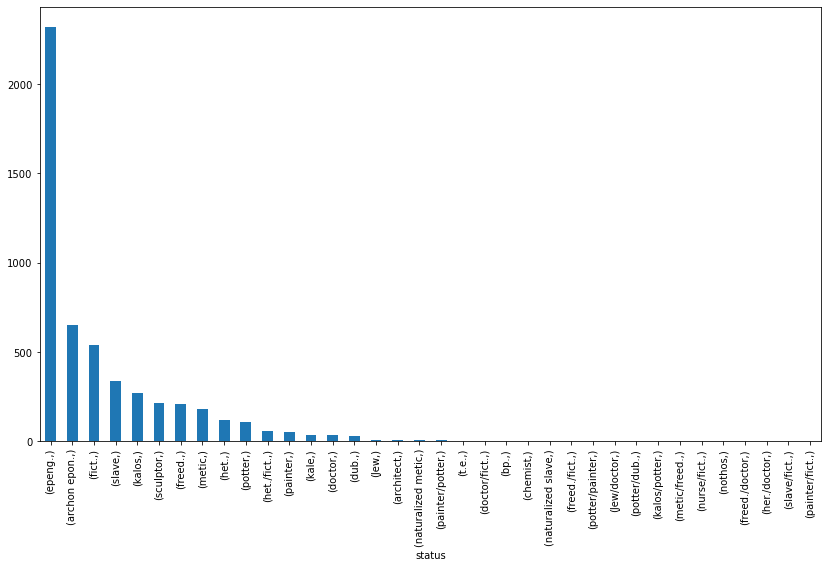

In [5]:
individuals_with_status.value_counts(subset=["status"]).plot(kind='bar', figsize=(14,8))

In [352]:
# TODO get this working. And when it is, remove column-renaming code for attica.csv above
attica.to_csv(os.path.join(".", "data", "csv", "attica-renamed.csv"), index=False)

# Visualize geographical distribution of individuals


In [88]:
all_location_occurrences = list(zip(input_df["lat"].dropna().to_list(), input_df["long"].dropna().to_list()))
counts_of_locations = Counter(all_location_occurrences)

# center the map (arbitrarily) on the first lat-long point in the data 
root_location = all_location_occurrences[0]

# create map object
folium_map = folium.Map(location=root_location,
                        zoom_start=8,
                        tiles="CartoDB dark_matter")

# add to map circles whose area is proportional to the number of
# individuals from that location
for loc in counts_of_locations:
    count = counts_of_locations[loc]
    radius = np.sqrt(count/50)
    folium.CircleMarker(location=loc, radius=radius, fill=True).add_to(folium_map)

# display map
folium_map

# Learning association rules

Here we derive association rules between sets of syllables in a person's name and their social status. See the wikipedia article on [association rule learning](https://en.wikipedia.org/wiki/Association_rule_learning) for a more thorough introduction to the association rule setup than we provide below. 

### Assocation rules in the setting of Greek names and social statuses
The association rule literature usually frames its problem in terms of "baskets (or transactions)", "items", and "itemsets". This is referred to as the market basket model, reflecting the origins of association rule learning in recommendation systems and the analysis of actual shopping baskets of items purchased by individuals. Our setting of ancient Greek individuals and their status maps onto the market basket model as follows:
- the "baskets" are individuals, represented as (the syllables in their name) + (their status)
- the "items" are the set of all attested name-syllables and statuses
- the "itemsets" are subsets of this set of possible syllables and statuses

Since we are interested in what can be learned about an individual's social status based on their personal name alone, we will only be considering association rules of the form SYLLABLE SET --> STATUS. We derive association rules involving itemsets which occur more than `min-support` times in the dataset of individuals. The **support** of an itemset is the number of individuals/baskets in the dataset which contain that itemset as a subset. For example the support of {μα, νης, slave}, denoted **supp**({μα, νης, slave}), is the number of individuals in the dataset whose name contains the syllables μα and νης, and whose social status is "slave". The support of the itemset {μα, νης} is the number of individuals whose name contains the syllables μα and νης, regardless of their social status.


We implement the following two measures of the "interest" or "strength" of an association rule:

1. **Confidence.**
The confidence of an association rule {μα, νης} --> {slave} is defined as 
$$\frac{\textbf{supp}(\{ \text{μα, νης, slave}\})}{\textbf{supp}(\{ \text{μα, νης\}})}$$

We can interpret confidence probabilistically, as the conditional probability that an individual is a slave, given that their name contains the syllables {μα, νης}:
$$\textbf{Pr}(\text{slave}|{\text{μα, νης}})$$
That is, the probability that a person selected uniformly at random from people whose name contains syllables {μα, νης} is a slave.


2. **Lift.** 
The lift of an association rule {μα, νης} --> {slave} is defined as 

$$\frac{ 
\textbf{supp}(\{ \text{μα, νης, slave}\}) \cdot \text{total_num_individuals}
}
{
\textbf{supp}(\{ \text{μα, νης\}}) \cdot \textbf{supp}(\{ \text{slave\}})
}$$
   
Lift also has the following, more intuitive, definition under a probabilistic interpretation. Letting $\textbf{Pr}(\{a, b, c\})$ denote
$$\frac{\textbf{supp}(\{ \text{μα, νης, slave}\})} {\text{total_num_individuals}}, $$
i.e. the (unconditional) probability that an individual/basket selected uniformly at random from the dataset contains items {a, b, c}, the lift of the rule {μα, νης} --> {slave} becomes
 
$$\frac{ 
\textbf{Pr}(\{ \text{μα, νης, slave}\}) 
}
{
\textbf{Pr}(\{ \text{μα, νης\}}) \cdot \textbf{Pr}(\{ \text{slave\}})
}$$

Lift measures how much the empirical probability of seeing {μα, νης, slave} in the same basket in our dataset diverges from what the probability of seeing them together would be if {μα, νης} and {slave} occurred independently of one another.
- Lift ranges from 0 to infinity. 
- A lift of 1 would indicate that {μα, νης} and {slave} co-occur as often as we would expect (on the assumption they are independent) from chance alone
- A lift greater than 1 would indicate that {μα, νης} and {slave} co-occur more often than we would expect from chance alone.
- A lift of less than 1 indicates that that {μα, νης} and {slave} co-occur less often than we would expect from chance alone.

In information-theoretic terms, the logarithm of lift is the [pointwise mutual information](https://en.wikipedia.org/wiki/Pointwise_mutual_information) between the event of seeing {μα, νης} and the event of seeing {slave}.



### Implementing association rule learning

In [57]:
############ Featurize each individual's name as a set of syllables.
#### normalizing and syllabifying Ancient Greek name
def normalize(string):
    """Lowercase string of Greek characters and remove accents."""
    normalise = Normaliser().normalise
    return strip_accents(normalise(string)[0])

def make_syllables(string):
    """Return a list of the name's syllables."""
    return syllabify(normalize(string))

#### adding feature representations of names to dataframe  
def add_feature_col(df, feature_fn, feature_name):
    with_features = df.copy()
    with_features[feature_name] = with_features["name"].map(
        lambda name: feature_fn(name)
    )
    return with_features

#### adding "baskets" of features + status to rows where status is not NaN 
def add_status_basket_col(df, feature_name):
    """add new column that is the original feature list with the individual's
    status string appended to it. Expects a df with no missing values in status column.""" 
    status_basket_col = df[feature_name] + df["status"].map(lambda string: [string])
    with_status_basket = df.copy()
    with_status_basket[f"{feature_name}Basket"] = status_basket_col
    return with_status_basket
        
def prepare_df_with_syllable_features(input_df):
    df_featured = add_feature_col(input_df, make_syllables, "syllables")
    df_has_status = df_featured.dropna(subset=["status"])
    df_with_status_baskets = add_status_basket_col(df_has_status, "syllables")
    df_syllables_exploded = df_with_status_baskets.explode("syllablesBasket")
    return df_syllables_exploded["syllablesBasket"]


############ Find frequencies of itemsets (sets of name syllables + status).
def get_item_ntuples(order_item, n):
    order_item = order_item.reset_index().to_numpy()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):  
        item_list = [item[1] for item in order_object]
        
        for item_ntuple in combinations(item_list, n):
            yield item_ntuple

def make_frequency_dict(feature_baskets, max_itemset_size=5):
    freq_dict = dict()
    for n in range(1, max_itemset_size):
        size_n_itemsets = Counter(get_item_ntuples(feature_baskets, n))
        freq_dict.update(size_n_itemsets)
    return freq_dict

def extract_itemsets_with_status(freq_dict, status_set):
    itemsets_with_status = []
    for itemset, freq in freq_dict.items():
        if itemset[-1] in status_set and len(itemset) > 1:
            itemsets_with_status.append(itemset)
    return itemsets_with_status


############ Derive association rules between syllable-sets and statuses.
def get_syllables(itemset):
    """Extract features from basket (tuple), assuming they are
    all but the last item."""
    return itemset[:-1]

def get_status(itemset):
    """Extract status from basket, assuming it is the
    last item in the basket."""
    return itemset[-1:]

def confidence(itemset):
    syllables = get_syllables(itemset)
    return freq_dict[itemset] / freq_dict[syllables]

def lift(itemset, total_num_baskets):
    syllables = get_syllables(itemset)
    status = get_status(itemset) 
    return (freq_dict[itemset] * NUM_BASKETS) / (freq_dict[syllables] * freq_dict[status])

def make_association_rules_df(itemsets_with_status, min_support=4):
    """Construct a dataframe with all association rules involving itemsets with
    support greater than min_support."""
    df = pd.DataFrame(pd.Series(itemsets_with_status), columns=["itemset"])
    df["support"] = df["itemset"].apply(lambda itemset: freq_dict[itemset])
    df["syllables"] = df["itemset"].apply(get_syllables)
    df["status"] = df["itemset"].apply(get_status).apply(lambda status: status[0])
    df["confidence"] = df["itemset"].apply(confidence)
    df["lift"] = df["itemset"].apply(lambda itemset: lift(itemset, len(individuals_with_status)))
    df = df[df["support"] >= min_support]
    return df

In [81]:
feature_baskets = prepare_df_with_syllable_features(input_df)
freq_dict = make_frequency_dict(feature_baskets)
itemsets_with_status = extract_itemsets_with_status(freq_dict, status_set)
rules = make_association_rules_df(itemsets_with_status, min_support=3)
rules.head()

,itemset,support,syllables,status,confidence,lift
0,"(ἀ, epeng.)",284,"(ἀ,)",epeng.,0.595388,1.342063
1,"(βα, epeng.)",19,"(βα,)",epeng.,0.703704,1.586217
2,"(σκαν, epeng.)",13,"(σκαν,)",epeng.,1.000000,2.254098
3,"(τος, epeng.)",151,"(τος,)",epeng.,0.479365,1.080536
7,"(στης, epeng.)",3,"(στης,)",epeng.,1.000000,2.254098


### Inspect rules for interesting associations
The following is specific to Attica and its attested statuses, but results are similar for other regions. 

Aficionados of Ancient Greek naming practices and social history will recognize a number of interesting associations that the method has uncovered involving the names of slaves, freedpersons (abbreviated "freed."), and prostitutes (abbreviated "het.")




To begin, observe that the very high lift and confidence values of some rules is an artifact of our 
low support threshold of 3. 

In [83]:
rules.sort_values(by=["lift","confidence"], ascending=False).head(50)

,itemset,support,syllables,status,confidence,lift
11324,"(πο, γνω, painter)",3,"(πο, γνω)",painter,1.000000,104.500000
11326,"(λυ, γνω, painter)",3,"(λυ, γνω)",painter,1.000000,104.500000
19791,"(πο, λυ, γνω, painter)",3,"(πο, λυ, γνω)",painter,1.000000,104.500000
19793,"(πο, γνω, τος, painter)",3,"(πο, γνω, τος)",painter,1.000000,104.500000
19794,"(λυ, γνω, τος, painter)",3,"(λυ, γνω, τος)",painter,1.000000,104.500000
7882,"(θα, ϊς, het./fict.)",3,"(θα, ϊς)",het./fict.,1.000000,90.086207
851,"(χις, het./fict.)",3,"(χις,)",het./fict.,0.600000,54.051724
11328,"(γνω, τος, painter)",3,"(γνω, τος)",painter,0.500000,52.250000
8155,"(τα, λη, het./fict.)",3,"(τα, λη)",het./fict.,0.500000,45.043103
2607,"(γνω, painter)",3,"(γνω,)",painter,0.428571,44.785714


Let's now try to drill down to some strong associations that appear to be more robust.

In [89]:
statuses_to_include = {
   "slave",
    "het.",
    "freed.",
} 

statuses_to_exclude = {
    "epeng.",
    "fict.",
    "archon epon.",
}

def include_statuses(rules, statuses_to_include):
    return rules[rules["status"].isin(statuses_to_include)]

def exclude_statuses(rules, statuses_to_exclude):
    return rules[~rules["status"].isin(statuses_to_exclude)]

def filter_by_confidence(rules, lower, upper):
    """Selects rules whose confidence lies within a certain range.
    A good starting point is to look at rules with confidence between
    0.5 and 1.0."""
    return rules[
        (rules["confidence"] >= lower) &
        (rules["confidence"] <= upper)].sort_values(by=["support","lift"], ascending=False)

In [86]:
filter_by_confidence(include_statuses(rules, statuses_to_include), 0.5, 1.0)

,itemset,support,syllables,status,confidence,lift
9770,"(μα, νης, slave)",11,"(μα, νης)",slave,0.785714,12.218325
12218,"(συ, ρος, slave)",9,"(συ, ρος)",slave,0.750000,11.662946
923,"(γη, slave)",9,"(γη,)",slave,0.529412,8.232668
924,"(ρυς, slave)",8,"(ρυς,)",slave,1.000000,15.550595
1731,"(θραιξ, slave)",8,"(θραιξ,)",slave,1.000000,15.550595
5519,"(γη, ρυς, slave)",8,"(γη, ρυς)",slave,1.000000,15.550595
8892,"(κα, ρι, slave)",8,"(κα, ρι)",slave,0.727273,11.309524
4864,"(κα, ων, slave)",8,"(κα, ων)",slave,0.571429,8.886054
18201,"(κα, ρι, ων, slave)",7,"(κα, ρι, ων)",slave,0.875000,13.606771
5575,"(νι, ον, het.)",6,"(νι, ον)",het.,0.545455,23.360656


In [87]:
filter_by_confidence(exclude_statuses(rules, {"epeng."}), 0.5, 1.0).head(50)

,itemset,support,syllables,status,confidence,lift
9654,"(λυ, σι, archon epon.)",16,"(λυ, σι)",archon epon.,0.571429,4.593407
9657,"(σι, δης, archon epon.)",14,"(σι, δης)",archon epon.,0.666667,5.358974
5812,"(δη, μο, archon epon.)",14,"(δη, μο)",archon epon.,0.608696,4.892977
9437,"(λα, χης, fict.)",12,"(λα, χης)",fict.,0.857143,8.309038
9770,"(μα, νης, slave)",11,"(μα, νης)",slave,0.785714,12.218325
9623,"(λυ, δης, archon epon.)",11,"(λυ, δης)",archon epon.,0.785714,6.315934
637,"(χη, fict.)",10,"(χη,)",fict.,0.769231,7.456829
18657,"(λυ, σι, δης, archon epon.)",10,"(λυ, σι, δης)",archon epon.,0.909091,7.307692
6003,"(ο, κλης, archon epon.)",10,"(ο, κλης)",archon epon.,0.555556,4.465812
12218,"(συ, ρος, slave)",9,"(συ, ρος)",slave,0.750000,11.662946
